<a href="https://colab.research.google.com/github/Syed-Osama-Hussain/Imagined-Speech-Prediction-from-EEG/blob/master/long_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This file contains the models tested on long words with two classes (1="cooperate",2="Independent"). First we visualize the data, then preprocess it. Followed by CNN, RNN, stacked model and combined model along with their evaluations, respectively.

#Imports:
First we import the necessary libraries. Keras is used to build the model. Sklearn, matplotlib and seaborn are used for visualization. Scipy is used to read the data in the mat files and numpy for mathematical operations.

In [ ]:
import numpy as np
import tensorflow as tf
import scipy.io
import scipy.interpolate
import os
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Dropout, Input, Reshape, GRU
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras.models import Model, load_model
import keras.backend as K
from tensorflow.keras.optimizers import Adam

#Connect Drive:
The data set is available on google drive so we mount it first.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Data Visualization:
In this section we visualize the data in different formats.

In [ ]:
!ls "drive/My Drive/dataset/Long_words/"

sub_11b_ch64_l_eog_removed_256Hz.mat  sub_7_ch64_l_eog_removed_256Hz.mat
sub_2b_ch64_l_eog_removed_256Hz.mat   sub_9c_ch64_l_eog_removed_256Hz.mat
sub_6_ch64_l_eog_removed_256Hz.mat


Data is read using scipy from a single file, since it is in a .mat file and the first value for each variable is printed. It is evident that printing these values doesn't give away much information.

In [ ]:
mat = scipy.io.loadmat("drive/My Drive/dataset/Long_words/sub_2b_ch64_l_eog_removed_256Hz")
end_trial = mat['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
last_beep = mat['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']

In [ ]:
print(end_trial[0][0])

[[  2.0756692    3.3451948    1.2805819  ...   1.03499391  -1.8243698
   -1.01871216]
 [ -3.82600849 -11.7789427  -19.90806902 ...  12.53093915   8.48127123
   11.22360224]
 [ -3.00310901  -5.53589825 -10.7160167  ...   8.79775373   5.17229481
    8.20442485]
 ...
 [ -3.28631204 -12.27128688 -21.85336011 ...   7.17226805   4.4037043
    6.18084104]
 [ -1.91263385  -4.37623631  -7.82609212 ...   1.17744386  -3.16380532
    0.43488985]
 [  2.51450495   6.26755729   2.75070428 ...   1.19598115  -4.54512732
   -1.76451922]]


In [ ]:
print(end_trial[1][0])

[[ -1.27735546  -3.82002997  -2.88641743 ...   1.9763067    2.05661518
    1.3593881 ]
 [ -4.90701477  -8.48444293  -5.82129236 ...  -2.30271976  -0.36951821
    1.3378214 ]
 [ -5.40068243  -9.89625475  -7.20670153 ...  -1.60120045   0.36174521
    4.19075407]
 ...
 [ -5.3620891   -9.69451373  -6.31911269 ...  -3.00807071   0.27529782
    2.78197364]
 [ -6.75004416 -11.84629843  -7.65657429 ...  -0.45278445   0.70701181
    1.51307907]
 [ -6.31367576  -8.92761731  -4.09098874 ...   7.03288896   4.97767805
    3.63721799]]


##Visualization from Simple Graphs:
Although there is not much information we can obtain from these graphs without having a neuroscience background but one thing is evident that both classes have visibily different values.




###Cooperate in resting state

First value representing the resting state variable for the first class (matrix of dimensions 64x512). 

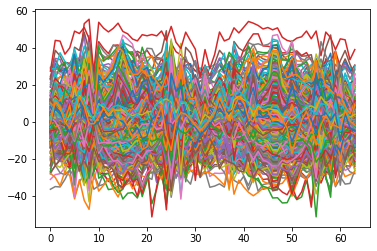

In [ ]:
plt.plot(end_trial[0][0]);

### Cooperate during speech imagery state
First value representing the speech imagery state variable for the first class (matrix of dimensions 64x1280).

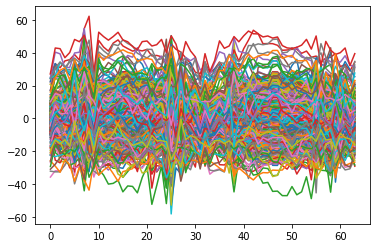

In [ ]:
plt.plot(last_beep[0][0]);

###Independent during resting state
First value representing the resting state variable for the second class (matrix of dimensions 64x512).

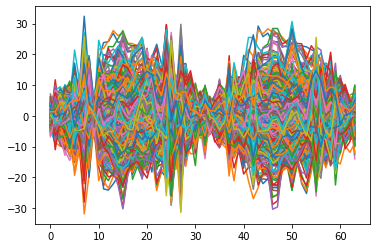

In [ ]:
plt.plot(end_trial[1][0]);

###Independent during speech imagery state
First value representing the speech imagery state variable for the second class (matrix of dimensions 64x1280).

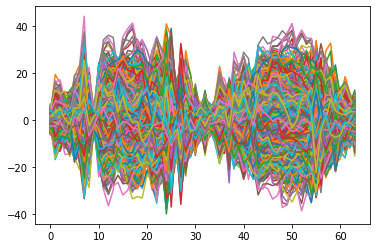

In [ ]:
plt.plot(last_beep[1][0]);

##Visualization through mean Graphs:
Since EEG waves can be viewed as a multivariate time series problem we calculate row wise mean for the time series and visualize the graphs.

First class

In [ ]:
meanArray = np.mean(last_beep[0][0], axis=1)
print(meanArray.shape,meanArray)

(64,) [-0.13003854  0.24455359  0.22633897  0.03307268  0.03230343  0.28888179
  0.35252482  0.69063385  0.25675194 -0.13003854  0.43125741  0.59353889
  0.69763533  0.59324108  0.3639039   0.59934937  0.79675421  0.68367328
  0.5721425   0.69114908  0.51009123  0.55699642  0.51882982  0.44788933
  0.48034036  0.43533081  0.26509542  0.42561071  0.46316792  0.38164263
  0.23426558 -0.08574821  0.02762148 -0.06708668  0.17042289  0.36870453
  0.15811592  0.22793883  0.33362535  0.392588    0.53293808  0.39895962
  0.54867538  0.52250932  0.61001162  0.63915052  0.55138293  0.60611238
  0.70982551  0.61902812  0.65248881  0.54557698  0.60910961  0.53114095
  0.52549741  0.56787023  0.31514181  0.43895366  0.36331172  0.38117011
  0.18251426  0.36371877  0.10645498  0.02762148]


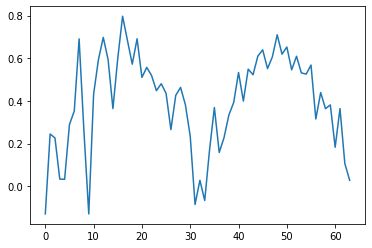

In [ ]:
plt.plot(meanArray)

Second class

In [ ]:
meanArray2 = np.mean(last_beep[1][0], axis=1)
print(meanArray2.shape,meanArray2)

(64,) [ 0.06539597 -0.19936059 -0.05575872 -0.01826646  0.04464276  0.00929552
 -0.24796776 -0.04738479  0.17058939  0.06539597  0.04649077  0.07812
  0.11608703  0.104319    0.15625751  0.14576939  0.1115684   0.11581559
  0.05716779  0.11281127  0.18667023  0.07652098 -0.05757944 -0.1427817
 -0.08334915 -0.04803876  0.05565032  0.04173244 -0.15868506 -0.2056671
  0.02464144  0.06787134  0.04764045  0.08361487 -0.09319137 -0.2464197
 -0.0643206   0.02687742 -0.09094325 -0.17954623 -0.12855244  0.05386437
  0.15192126  0.10096513  0.11710045  0.10045269  0.13612577  0.10992441
  0.02832354  0.06519232  0.13900616  0.03981508  0.08234334  0.01332629
  0.012574    0.09825389  0.05105055 -0.15364991 -0.13914449  0.0656384
 -0.04117108 -0.18436445 -0.08319188  0.04764045]


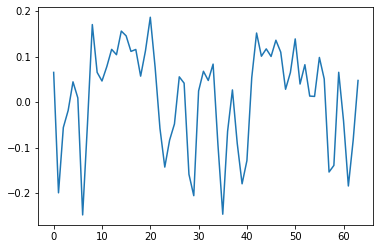

In [ ]:
plt.plot(meanArray2)

##Brain Plot:
Here we visualize the EEG signals by plotting them on a graphical representation of the head. 

First class

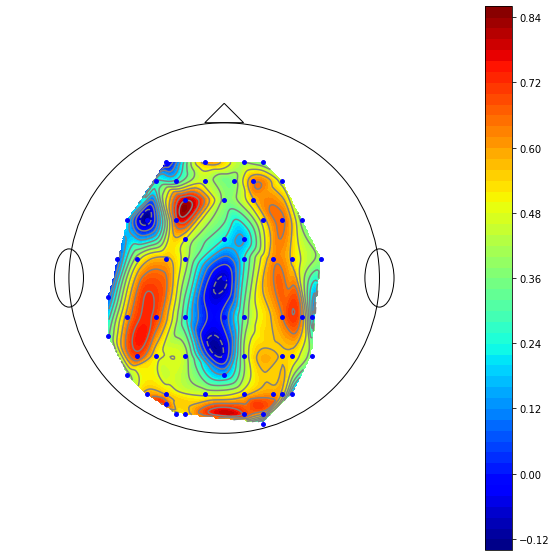

In [ ]:

# close old plots
plt.close("all")

# some parameters
N = 300             # number of points for interpolation
xy_center = [8,11]   # center of the plot
radius = 8          # radius

# Row wise mean
meanR = np.mean(last_beep[0][0], axis=1)

#For Anterior posterior bipolar montage 9 rows
koord = [[5,17],[4.5,16],[3,14],[2.5,12],[2,10],[2,8],[3,6],[5,4.5],   #8 channels
         [5.5,16],[4,14],[3.5,12],[3,9],[3.5,7],[4,5],[5.5,4],  #7 channels
         [7,17],[6,15],[5.5,14],[5,12],[4.5,9],[4.5,7],[5,5],[6,4], #8 channels
         [7,16],[6,13],[6,12],[6,9],[6,7],[7,5], #6 channels
         [8,15],[8,13],[8,11],[8,9],[8,7],[8,6], #6 channels
         [8.5,16],[9,13],[9,12],[9,9],[9,7],[9,5], #6 channels
         [9,17],[9.5,15],[10,14],[10.5,12],[11,9],[11,7],[10.5,5],[9,4], #8 channels 
         [9.5,16],[11,14],[11.5,12],[12,9],[11.5,7],[11,5],[10,4],  #7 channels 
         [10,17],[11,16],[12,14],[13,12],[12.5,9],[12.5,7],[11.5,5],[10,3.5],   #8 channels
         ]
# koord = [[1,4],[3,4],[1,3],[3,3],[2,3],[1,2],[3,2],[2,2],[1,1],[3,1],[2,1],[1,0],[3,0],[0,3],[4,3],[0,2],[4,2],[0,1],[4,1]]

x,y = [],[]
for i in koord:
    x.append(i[0])
    y.append(i[1])

z = meanR

xi = np.linspace(-2, 25, N)
yi = np.linspace(-2, 25, N)
zi = scipy.interpolate.griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

# set points > radius to not-a-number. They will not be plotted.
# the dr/2 makes the edges a bit smoother
dr = xi[1] - xi[0]
for i in range(N):
    for j in range(N):
        r = np.sqrt((xi[i] - xy_center[0])**2 + (yi[j] - xy_center[1])**2)
        if (r - dr/2) > radius:
            zi[j,i] = "nan"

# make figure

fig = plt.figure(figsize=(10, 10))

# set aspect = 1 to make it a circle
ax = fig.add_subplot(111, aspect = 1)

# use different number of levels for the fill and the lines
CS = ax.contourf(xi, yi, zi, 60, cmap = plt.cm.jet, zorder = 1)
ax.contour(xi, yi, zi, 15, colors = "grey", zorder = 2)

# make a color bar
cbar = fig.colorbar(CS, ax=ax)

# add the data points
# I guess there are no data points outside the head...
ax.scatter(x, y, marker = 'o', c = 'b', s = 15, zorder = 3)

# draw a circle
# change the linewidth to hide the 
circle = matplotlib.patches.Circle(xy = xy_center, radius = radius, edgecolor = "k", facecolor = "none")
ax.add_patch(circle)

# make the axis invisible 
for loc, spine in ax.spines.items():
    # use ax.spines.items() in Python 3
    spine.set_linewidth(0)

# remove the ticks
ax.set_xticks([])
ax.set_yticks([])

# Add some body parts. Hide unwanted parts by setting the zorder low
# add two ears
circle = matplotlib.patches.Ellipse(xy = [0,11], width = 1.5, height = 3.0, angle = 0, edgecolor = "k", facecolor = "w", zorder = 0)
ax.add_patch(circle)
circle = matplotlib.patches.Ellipse(xy = [16,11], width = 1.5, height = 3.0, angle = 0, edgecolor = "k", facecolor = "w", zorder = 0)
ax.add_patch(circle)
# add a nose
xy = [[7,19], [8,20],[9,19]]
polygon = matplotlib.patches.Polygon(xy = xy,edgecolor = "k", facecolor = "w", zorder = 0)
ax.add_patch(polygon) 

# set axes limits
ax.set_xlim(-3, 20)
ax.set_ylim(-1, 23)

plt.show() 

Second class

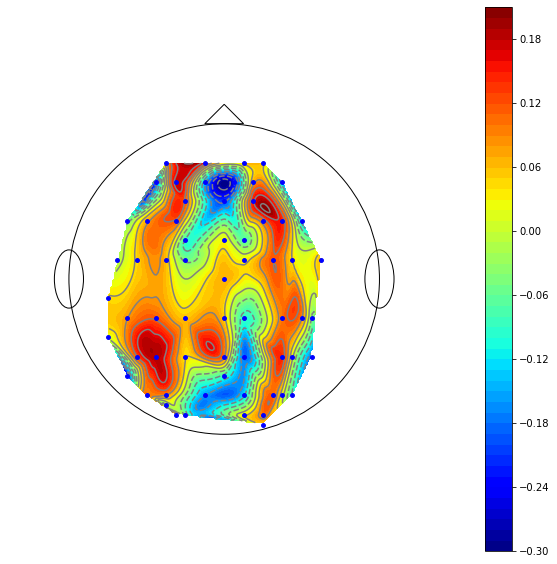

In [ ]:

# close old plots
plt.close("all")

# some parameters
N = 300             # number of points for interpolation
xy_center = [8,11]   # center of the plot
radius = 8          # radius

# Row wise mean
meanR = np.mean(last_beep[1][0], axis=1)

#For Anterior posterior bipolar montage 9 rows
koord = [[5,17],[4.5,16],[3,14],[2.5,12],[2,10],[2,8],[3,6],[5,4.5],   #8 channels
         [5.5,16],[4,14],[3.5,12],[3,9],[3.5,7],[4,5],[5.5,4],  #7 channels
         [7,17],[6,15],[5.5,14],[5,12],[4.5,9],[4.5,7],[5,5],[6,4], #8 channels
         [7,16],[6,13],[6,12],[6,9],[6,7],[7,5], #6 channels
         [8,15],[8,13],[8,11],[8,9],[8,7],[8,6], #6 channels
         [8.5,16],[9,13],[9,12],[9,9],[9,7],[9,5], #6 channels
         [9,17],[9.5,15],[10,14],[10.5,12],[11,9],[11,7],[10.5,5],[9,4], #8 channels 
         [9.5,16],[11,14],[11.5,12],[12,9],[11.5,7],[11,5],[10,4],  #7 channels 
         [10,17],[11,16],[12,14],[13,12],[12.5,9],[12.5,7],[11.5,5],[10,3.5],   #8 channels
         ]
# koord = [[1,4],[3,4],[1,3],[3,3],[2,3],[1,2],[3,2],[2,2],[1,1],[3,1],[2,1],[1,0],[3,0],[0,3],[4,3],[0,2],[4,2],[0,1],[4,1]]

x,y = [],[]
for i in koord:
    x.append(i[0])
    y.append(i[1])

z = meanR

xi = np.linspace(-2, 25, N)
yi = np.linspace(-2, 25, N)
zi = scipy.interpolate.griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

# set points > radius to not-a-number. They will not be plotted.
# the dr/2 makes the edges a bit smoother
dr = xi[1] - xi[0]
for i in range(N):
    for j in range(N):
        r = np.sqrt((xi[i] - xy_center[0])**2 + (yi[j] - xy_center[1])**2)
        if (r - dr/2) > radius:
            zi[j,i] = "nan"

# make figure
fig = plt.figure(figsize=(10, 10))

# set aspect = 1 to make it a circle
ax = fig.add_subplot(111, aspect = 1)

# use different number of levels for the fill and the lines
CS = ax.contourf(xi, yi, zi, 60, cmap = plt.cm.jet, zorder = 1)
ax.contour(xi, yi, zi, 15, colors = "grey", zorder = 2)

# make a color bar
cbar = fig.colorbar(CS, ax=ax)

# add the data points
# I guess there are no data points outside the head...
ax.scatter(x, y, marker = 'o', c = 'b', s = 15, zorder = 3)

# draw a circle
# change the linewidth to hide the 
circle = matplotlib.patches.Circle(xy = xy_center, radius = radius, edgecolor = "k", facecolor = "none")
ax.add_patch(circle)

# make the axis invisible 
for loc, spine in ax.spines.items():
    # use ax.spines.items() in Python 3
    spine.set_linewidth(0)

# remove the ticks
ax.set_xticks([])
ax.set_yticks([])

# Add some body parts. Hide unwanted parts by setting the zorder low
# add two ears
circle = matplotlib.patches.Ellipse(xy = [0,11], width = 1.5, height = 3.0, angle = 0, edgecolor = "k", facecolor = "w", zorder = 0)
ax.add_patch(circle)
circle = matplotlib.patches.Ellipse(xy = [16,11], width = 1.5, height = 3.0, angle = 0, edgecolor = "k", facecolor = "w", zorder = 0)
ax.add_patch(circle)
# add a nose
xy = [[7,19], [8,20],[9,19]]
polygon = matplotlib.patches.Polygon(xy = xy,edgecolor = "k", facecolor = "w", zorder = 0)
ax.add_patch(polygon) 

# set axes limits
ax.set_xlim(-3, 20)
ax.set_ylim(-1, 23)
plt.show() 

#Data Preprocessing:
In this section we read the data, calculate covariance matrices and label the data for training using the models in the subsequent sections.

##Covariance Matrix Calculation

In [ ]:
def covariance(matrix):
  res_mat = (np.cov(matrix,bias=True))
  return res_mat

##Load Matrices:
Here we load matrices for both classes from all files in the directory.

In [ ]:
def loadMatrices(dir):
  matrices_c1 = []
  matrices_c2 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      if f == "Read_me.txt":
        continue
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      end_trial = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in end_trial[0]])
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in end_trial[1]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2)),axis=0)


##Data Preparation

In [ ]:
data = loadMatrices("drive/My Drive/dataset/Long_words/")

In [ ]:
print(data.shape)

(2000, 64, 64)


In [ ]:
for dat in data[0]:
  print(dat.tolist(),"\n")

[5.09488053522139, 5.782477273312003, 6.045019205265657, 4.918112223835817, 3.7713490370887848, 6.163118117741021, 6.457125742180011, 6.737499292320196, 4.709317825277367, 5.094880535221539, 5.7410229184036385, 7.037493057612561, 6.5748654070074455, 5.997017963866625, 4.33269419249672, 5.093914942844465, 5.477918094394963, 6.159252577517503, 6.635767062016772, 5.899046180211921, 4.9407758260207935, 5.815701684178222, 6.870191480576827, 6.259756074230329, 6.6845355139942715, 4.892186517911629, 4.313924753428963, 4.178851141348425, 5.595750874742504, 2.6332376297576126, 2.5449542277485726, 2.715790004305046, 4.25683369958485, 5.215798699464957, 3.640136640124391, 5.68338553691628, 5.284163627323767, 4.842615309632504, 6.784848003867667, 6.040102416205379, 6.397501898293501, 5.481597259720281, 4.363554297362491, 5.911802455860706, 6.710568296361796, 5.670256430126186, 5.321612865649194, 6.266868768206108, 6.637714556133348, 5.9151216005123715, 4.882533493257083, 6.082205002774335, 7.41265

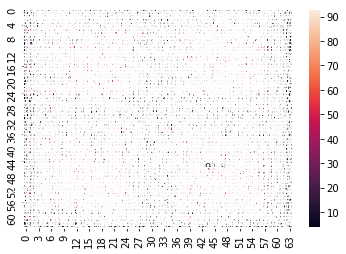

<Figure size 72x72 with 0 Axes>

In [ ]:
sns.heatmap(data[0], annot=True, fmt='.2f')
# plt.tight_layout()
plt.figure(figsize=(1,1))
# plt.savefig("cov_matrix_incl_anno_double.png",figsize=(50, 50))
plt.show()

In [ ]:
labels = np.concatenate((np.zeros(1000),np.ones(1000)),axis=0)
print(labels.shape)

(2000,)


In [ ]:
from keras.utils.np_utils import to_categorical
labels = to_categorical(labels, num_classes=2)
print(labels.shape,labels)

(2000, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


#CNN

##Model Design

In [ ]:

visible = Input(shape=(64,64))
#CNN
cov1 = Conv1D(filters=64, kernel_size=2, activation="relu")(visible)
dropout1 = Dropout(0.25)(cov1)
cov2 = Conv1D(filters=64, kernel_size=4, activation="relu")(dropout1)
dropout2 = Dropout(0.5)(cov2)
newShape = Reshape((60,64), name='newReshape')(dropout2)
f1 = Flatten()(newShape)
d1 = Dense(128, activation='relu')(f1)
d2 = Dense(128, activation='relu')(d1)
output = Dense(2, activation='softmax')(d2)
model = Model(inputs=visible, outputs=output)
# model=Sequential()

# model.add(Conv1D(filters=64, kernel_size=2, activation="relu" , input_shape=(64,64)))
# # model.add(MaxPooling1D(pool_size=6))
# model.add(Conv1D(filters=64, kernel_size=4, activation="relu", input_shape=(64,64)))
# # model.add(MaxPooling1D(pool_size=6))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))

# model.add(Dense(128, activation='relu'))
# model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 63, 64)            8256      
_________________________________________________________________
dropout (Dropout)            (None, 63, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 64)            16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
newReshape (Reshape)         (None, 60, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3840)             

In [ ]:
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

##Shuffling and Training

In [ ]:
data, labels = shuffle(data, labels)

In [ ]:
divide_percent = int(len(data)*0.2)
y_test = labels[0:divide_percent]
x_test = data[0:divide_percent]
train_data = data[divide_percent:len(data)]
train_labels = labels[divide_percent:len(labels)]

In [ ]:
print(y_test.shape,x_test.shape,train_data.shape,train_labels.shape)

(400, 2) (400, 64, 64) (1600, 64, 64) (1600, 2)


In [ ]:
data, labels = shuffle(data, labels)

In [ ]:
model.fit(train_data,train_labels,validation_data=(x_test,y_test),batch_size=64,epochs=100,verbose=1)

Epoch 1/100
25/25 [==============================] - 0s 11ms/step - loss: 6.5451 - accuracy: 0.4925 - val_loss: 5.7673 - val_accuracy: 0.4950
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 6.1810 - accuracy: 0.4950 - val_loss: 4.4094 - val_accuracy: 0.5050
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 5.8992 - accuracy: 0.4994 - val_loss: 2.5101 - val_accuracy: 0.5075
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 5.9573 - accuracy: 0.5050 - val_loss: 3.8658 - val_accuracy: 0.4950
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 6.2126 - accuracy: 0.4794 - val_loss: 3.4451 - val_accuracy: 0.5050
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 5.9252 - accuracy: 0.4913 - val_loss: 3.6473 - val_accuracy: 0.5075
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 5.9941 - accuracy: 0.4825 - val_loss: 3.3517 - val_accuracy: 0.5075
Epoch 8/100


##CNN Evaluation

In [ ]:
predictions = model.predict(x_test)

In [ ]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

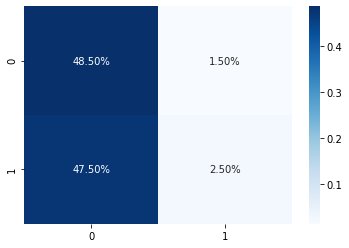

In [ ]:
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
print(rounded_predictions)

[1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0
 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1
 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1
 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 0
 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0
 1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 1
 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0
 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 1 0
 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0]


In [ ]:
print(rounded_labels)

[0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1
 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0
 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0
 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0
 1 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1
 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 1 0 1
 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1
 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1
 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1
 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1]


# RNN

In [ ]:
# visible = Input(shape=(64,64))
gru1 = GRU(64,activation="relu",return_sequences=True)(model.input)
dropout3 = Dropout(0.25)(gru1)
gru2 = GRU(64,activation="relu")(dropout3)
dropout4 = Dropout(0.5)(gru2)
d3 = Dense(64, activation='relu')(dropout4)
d4 = Dense(64, activation='relu')(d3)
output = Dense(2, activation='softmax')(d4)
model2 = Model(inputs=model.input, outputs=output)

# modelRNN = Sequential()
# modelRNN.add(GRU(64,activation="relu",return_sequences=True,input_shape=(64,64)))
# modelRNN.add(GRU(64,activation="relu"))
# modelRNN.add(Dense(64, activation='relu'))
# modelRNN.add(Dense(64, activation='relu'))

# # modelRNN.add(LSTM(64,activation="relu"))
# # modelRNN.add(Dense(64, activation='relu'))
# # modelRNN.add(Flatten())
# modelRNN.add(Dense(2, activation='softmax'))
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64)]          0         
_________________________________________________________________
gru (GRU)                    (None, 64, 64)            24960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

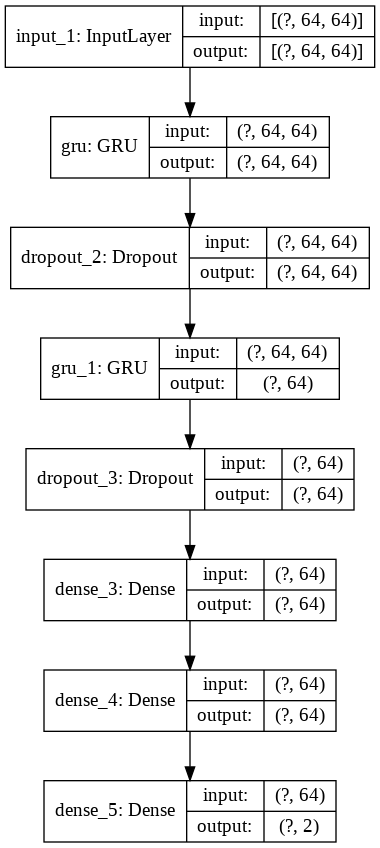

In [ ]:
plot_model(model2, show_shapes=True, to_file='model_graph.png')

In [ ]:
optimizer = Adam(learning_rate=0.00001)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model2.fit(train_data,train_labels,validation_data=(x_test,y_test),batch_size=64,epochs=100,verbose=1)

Epoch 1/100
25/25 [==============================] - 3s 107ms/step - loss: 3.7727 - accuracy: 0.4975 - val_loss: 2.3407 - val_accuracy: 0.5100
Epoch 2/100
25/25 [==============================] - 2s 95ms/step - loss: 3.4819 - accuracy: 0.5213 - val_loss: 2.1285 - val_accuracy: 0.5025
Epoch 3/100
25/25 [==============================] - 2s 91ms/step - loss: 3.5366 - accuracy: 0.4956 - val_loss: 1.9624 - val_accuracy: 0.5050
Epoch 4/100
25/25 [==============================] - 2s 92ms/step - loss: 3.3014 - accuracy: 0.4969 - val_loss: 1.7982 - val_accuracy: 0.5100
Epoch 5/100
25/25 [==============================] - 2s 91ms/step - loss: 3.2073 - accuracy: 0.4925 - val_loss: 1.6602 - val_accuracy: 0.5025
Epoch 6/100
25/25 [==============================] - 2s 94ms/step - loss: 2.9757 - accuracy: 0.4975 - val_loss: 1.5799 - val_accuracy: 0.5100
Epoch 7/100
25/25 [==============================] - 2s 85ms/step - loss: 2.8607 - accuracy: 0.4988 - val_loss: 1.4811 - val_accuracy: 0.5075
Epoch

In [ ]:
predictionsRNN = model2.predict(x_test)
np.round(predictionsRNN)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

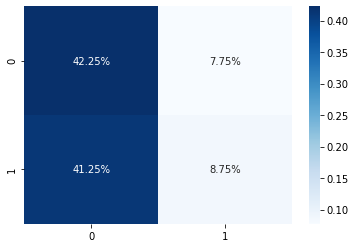

In [ ]:
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictionsRNN = np.argmax(predictionsRNN, axis=1)
cfRNN = confusion_matrix(rounded_labels,rounded_predictionsRNN)  # doctest: +SKIP
sns.heatmap(cfRNN/np.sum(cfRNN), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
print(rounded_predictionsRNN)

[1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0
 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 1
 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1
 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1]


In [ ]:
print(rounded_labels)

[1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0
 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0
 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1
 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0]


#Stacked Model

In [ ]:
for layer in model2.layers:
  print(layer)

Create two functions to get feature vector from CNN and RNN

In [ ]:
for layer in model.layers:
  layer.trainable = False

for layer in model2.layers:
  layer.trainable = False

In [ ]:
print([model.layers[8],model2.layers[6]])

[<tensorflow.python.keras.layers.core.Dense object at 0x7ff0201b1a20>, <tensorflow.python.keras.layers.core.Dense object at 0x7fefc70c78d0>]


In [ ]:
def createFeatureModel(modelCNN, modelRNN):
  outputs = [modelCNN.layers[8].output,modelRNN.layers[6].output]
  merge = concatenate(outputs)
  featureModel = Model(inputs=modelCNN.input, outputs=merge)
  return featureModel

In [ ]:
def extractFeatures(model, data):
  features = model.predict(data,verbose=0)
  return features

In [ ]:
featureModel = createFeatureModel(model,model2)
train_features = extractFeatures(featureModel, train_data)
test_features = extractFeatures(featureModel, x_test)
print(train_features.shape, test_features.shape)

(1600, 192) (400, 192)


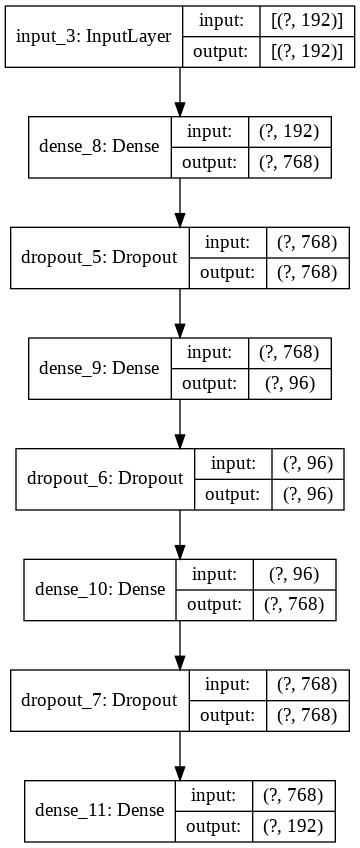

In [ ]:
# inputs = [model.input,model2.input]
# outputs = [model.layers[8],model2.layers[6]]
# print(outputs)
# merge = concatenate(outputs)

#DAE
daevisible = Input(shape=(192,))

encoder1 = Dense(768, activation='relu')(daevisible)
dropout5 = Dropout(0.25)(encoder1)
encoder2 = Dense(96, activation='sigmoid')(dropout5)
dropout6 = Dropout(0.25)(encoder2)
decoder1 = Dense(768, activation='relu')(dropout6)
dropout7 = Dropout(0.25)(decoder1)
decoder2 = Dense(192, activation='tanh')(dropout7)
model3 = Model(inputs=daevisible, outputs=decoder2)
plot_model(model3, show_shapes=True, to_file='model_graph.png')

In [ ]:
for i,layer in enumerate(model3.layers):
  print(i,layer)

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fefc66f4048>
1 <tensorflow.python.keras.layers.core.Dense object at 0x7fefc66f4240>
2 <tensorflow.python.keras.layers.core.Dropout object at 0x7fefc66f4208>
3 <tensorflow.python.keras.layers.core.Dense object at 0x7fefc66f44a8>
4 <tensorflow.python.keras.layers.core.Dropout object at 0x7fefc66f4588>
5 <tensorflow.python.keras.layers.core.Dense object at 0x7fefc66fc978>
6 <tensorflow.python.keras.layers.core.Dropout object at 0x7fefc66fc7b8>
7 <tensorflow.python.keras.layers.core.Dense object at 0x7fefc668d668>


In [ ]:
optimizer = Adam(learning_rate=0.00001)
model3.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['accuracy'])

In [ ]:
history = model3.fit(x=train_features, y=train_features,epochs=200,batch_size=64,validation_data=(test_features, test_features),verbose=1)

Epoch 1/200
25/25 [==============================] - 0s 6ms/step - loss: 428325.6250 - accuracy: 0.0031 - val_loss: 78.3986 - val_accuracy: 0.0175
Epoch 2/200
25/25 [==============================] - 0s 3ms/step - loss: 428324.4062 - accuracy: 0.0019 - val_loss: 78.2212 - val_accuracy: 0.0175
Epoch 3/200
25/25 [==============================] - 0s 3ms/step - loss: 428323.3125 - accuracy: 0.0037 - val_loss: 78.0831 - val_accuracy: 0.0175
Epoch 4/200
25/25 [==============================] - 0s 2ms/step - loss: 428322.4688 - accuracy: 0.0088 - val_loss: 77.9655 - val_accuracy: 0.0175
Epoch 5/200
25/25 [==============================] - 0s 3ms/step - loss: 428322.8750 - accuracy: 0.0125 - val_loss: 77.8467 - val_accuracy: 0.0175
Epoch 6/200
25/25 [==============================] - 0s 2ms/step - loss: 428322.2500 - accuracy: 0.0213 - val_loss: 77.7337 - val_accuracy: 0.0175
Epoch 7/200
25/25 [==============================] - 0s 3ms/step - loss: 428322.1562 - accuracy: 0.0244 - val_loss: 77

In [ ]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))    
    print('Mean for anomaly scores: ', np.mean(loss))
    return loss

In [ ]:
predictionsDAE = model3.predict(test_features,verbose=1)
scores = anomalyScores(test_features,predictionsDAE)

13/13 [==============================] - 0s 1ms/step
Mean for anomaly scores:  0.007303071


#Concatenated Model

##Model Design

In [ ]:

visible = Input(shape=(64,64))
#CNN
cov1 = Conv1D(filters=64, kernel_size=2, activation="relu")(visible)
dropout1 = Dropout(0.25)(cov1)
cov2 = Conv1D(filters=64, kernel_size=4, activation="relu")(dropout1)
dropout2 = Dropout(0.5)(cov2)
newShape = Reshape((60,64), name='newReshape')(dropout2)
f1 = Flatten()(newShape)
d1 = Dense(128, activation='relu')(f1)
d2 = Dense(128, activation='relu')(d1)

#RNN
gru1 = GRU(64,activation="relu",return_sequences=True)(visible)
gru2 = GRU(64,activation="relu")(gru1)
d3 = Dense(64, activation='relu')(gru2)
d4 = Dense(64, activation='relu')(d3)

#Merge
merge = concatenate([d2, d4])

#DAE
encoder1 = Dense(768, activation='relu')(merge)
encoder2 = Dense(96, activation='relu')(encoder1)
decoder1 = Dense(768, activation='relu')(encoder2)
decoder2 = Dense(192, activation='relu')(decoder1)

#FNN
hidden1 = Dense(64, activation='relu')(encoder2)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(2, activation='softmax')(hidden2)
model = Model(inputs=visible, outputs=output)
print(model.summary())

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64)]     0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 63, 64)       8256        input_4[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 63, 64)       0           conv1d_6[0][0]                   
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 60, 64)       16448       dropout_6[0][0]                  
_______________________________________________________________________________________

In [ ]:
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
data, labels = shuffle(data, labels)

In [ ]:
divide_percent = int(len(data)*0.2)
y_test = labels[0:divide_percent]
x_test = data[0:divide_percent]
train_data = data[divide_percent:len(data)]
train_labels = labels[divide_percent:len(labels)]

In [ ]:
print(y_test.shape,x_test.shape,train_data.shape,train_labels.shape)

(400, 2) (400, 64, 64) (1600, 64, 64) (1600, 2)


##Training

Epoch 1/200
25/25 [==============================] - 6s 249ms/step - loss: 2.0081 - accuracy: 0.4913 - val_loss: 13.0878 - val_accuracy: 0.4800
Epoch 2/200
25/25 [==============================] - 6s 228ms/step - loss: 1.5792 - accuracy: 0.4819 - val_loss: 9.9995 - val_accuracy: 0.4825
Epoch 3/200
25/25 [==============================] - 6s 233ms/step - loss: 1.4367 - accuracy: 0.4956 - val_loss: 5.5452 - val_accuracy: 0.4725
Epoch 4/200
25/25 [==============================] - 6s 229ms/step - loss: 1.4878 - accuracy: 0.5144 - val_loss: 10.4078 - val_accuracy: 0.4800
Epoch 5/200
25/25 [==============================] - 6s 229ms/step - loss: 1.2606 - accuracy: 0.5125 - val_loss: 15.3818 - val_accuracy: 0.4800
Epoch 6/200
25/25 [==============================] - 6s 230ms/step - loss: 1.2471 - accuracy: 0.5100 - val_loss: 19.5782 - val_accuracy: 0.4800
Epoch 7/200
25/25 [==============================] - 6s 239ms/step - loss: 1.1634 - accuracy: 0.5063 - val_loss: 19.9132 - val_accuracy: 0

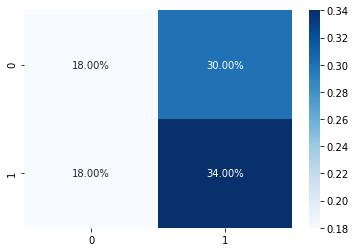

In [ ]:
# histories = []
# for i in range(10):
#   print("Iteration no ",i," for training \n=========\n=========\n=========")
train_data, train_labels = shuffle(train_data, train_labels)
# divide_percent = (len(train_data)*0.2)
# x_val = train_data[0:int(divide_percent)]
# y_val = train_labels[0:int(divide_percent)]
# x_train = train_data[int(divide_percent):len(train_data)]
# y_train = train_labels[int(divide_percent):len(train_labels)]
# print(x_val.shape, y_val.shape, x_train.shape, y_train.shape)

history = model.fit(train_data,train_labels,validation_data=(x_test,y_test),batch_size=65,epochs=200,verbose=1)
predictions = model.predict(x_test,verbose=0)
np.round(predictions)
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')
# histories.append(history)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model train vs validation loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper right')
plt.show()

##Evaluation

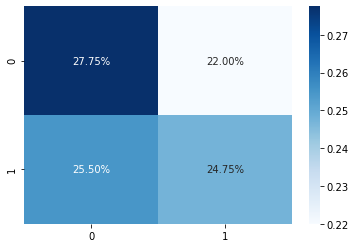

In [ ]:
predictions = model.predict(x_test,verbose=0)
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

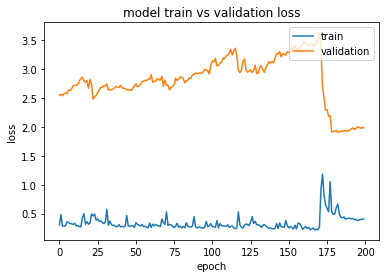

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#Accuracy Test

In [ ]:
model.save("model_long_words.h5")

Test on unseen data

In [ ]:
model = load_model("drive/My Drive/models/model_long_words.h5")
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 63, 64)       8256        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 60, 64)       16448       conv1d[0][0]                     
__________________________________________________________________________________________________
newReshape (Reshape)            (None, 60, 64)       0           conv1d_1[0][0]                   
_______________________________________________________________________________________

In [ ]:
def loadTestMatrices(data):
  matrices_c1 = []
  matrices_c1.extend([covariance(matrix) for matrix in data[0]])
  return np.array(matrices_c1)

In [ ]:
test_mat = scipy.io.loadmat("drive/My Drive/dataset/Short_Long_words/sub_1c_ch64_sl_eog_removed_256Hz_bw20")
last_beep = test_mat['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
test_data = loadTestMatrices(last_beep)
print(test_data.shape)

(100, 64, 64)


In [ ]:
test_labels = np.zeros(100)
print(test_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
from keras.utils.np_utils import to_categorical
test_labels = to_categorical(test_labels, num_classes=2)
print(test_labels.shape,test_labels)

(100, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


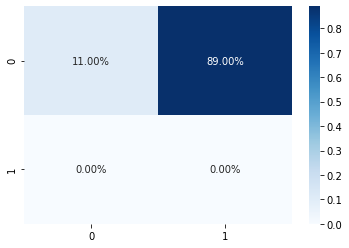

In [ ]:
  predictions_test = model.predict(test_data,verbose=0)
  np.round(predictions_test)
  rounded_labels_test = np.argmax(test_labels, axis=1)
  rounded_predictions_test = np.argmax(predictions_test, axis=1)
  cf_test = confusion_matrix(rounded_labels_test,rounded_predictions_test)  # doctest: +SKIP
  sns.heatmap(cf_test/np.sum(cf_test), annot=True, fmt='.2%', cmap='Blues')


In [ ]:
print(rounded_predictions_test)

[0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
print(rounded_labels_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
